In [1]:
# !pip install datasets==2.1.0
# !pip install transformers

import os
import json
import time
from tqdm import tqdm
import glob
from IPython.display import FileLink


import pandas as pd
import numpy as np
from collections import Counter, defaultdict

from matplotlib import pyplot as plt

import torch
import torchaudio
from datasets import load_dataset, load_metric, load_from_disk
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments, Trainer

In [2]:
# torchaudio.set_audio_backend("soundfile")

In [3]:
data_path = 'data/'
categories = os.listdir(data_path)
paths_and_cats = defaultdict(list)
k = 1048576

for i, category in enumerate(categories):
    
    audio_folder = f'{data_path}{category}/'
    audio_files = os.listdir(audio_folder)

    for audio_file in audio_files:
    
        file_path = f'{data_path}{category}/{audio_file}'
    
        if os.path.getsize(file_path) / k < 100:
        
            paths_and_cats['paths'].append(file_path)
            paths_and_cats['labels'].append(i)

In [4]:
len(paths_and_cats['paths']), len(paths_and_cats['labels'])

(385, 385)

In [5]:
paths = []
categories = []
for i in os.listdir("data/history/"):
    if os.path.getsize(f'data/history/{i}') / 1024 / 1024 < 100:
        categories += [0]
        paths += [f'data/history/{i}']
for i in os.listdir("data/art_music/"):
    if os.path.getsize(f'data/art_music/{i}') / 1024 / 1024 < 100:
        categories += [1]
        paths += [f'data/art_music/{i}']
for i in os.listdir("data/travel/"):
    if os.path.getsize(f'data/travel/{i}') / 1024 / 1024 < 100:
        categories += [2]
        paths += [f'data/travel/{i}']
for i in os.listdir("data/food/"):
    if os.path.getsize(f'data/food/{i}') / 1024 / 1024 < 100:
        categories += [3]
        paths += [f'data/food/{i}']

In [6]:
len(categories), len(paths)

(385, 385)

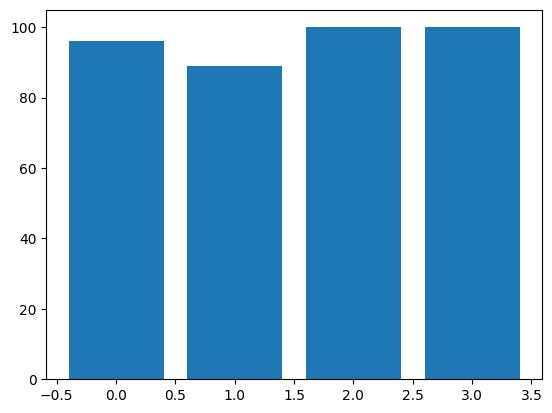

Counter({0: 96, 1: 89, 2: 100, 3: 100})

In [7]:
ct = Counter(categories)
plt.bar([x for x in ct.keys()], ct.values())
plt.show()
Counter(categories)

In [8]:
max_duration = 60

In [9]:
paths

['data/history/3400.mp3',
 'data/history/3405.mp3',
 'data/history/3406.mp3',
 'data/history/3408.mp3',
 'data/history/3410.mp3',
 'data/history/3412.mp3',
 'data/history/3413.mp3',
 'data/history/3416.mp3',
 'data/history/3417.mp3',
 'data/history/3420.mp3',
 'data/history/3421.mp3',
 'data/history/3422.mp3',
 'data/history/3425.mp3',
 'data/history/3427.mp3',
 'data/history/3428.mp3',
 'data/history/3430.mp3',
 'data/history/3431.mp3',
 'data/history/3433.mp3',
 'data/history/3435.mp3',
 'data/history/3436.mp3',
 'data/history/3438.mp3',
 'data/history/3439.mp3',
 'data/history/3440.mp3',
 'data/history/3441.mp3',
 'data/history/3444.mp3',
 'data/history/3448.mp3',
 'data/history/3449.mp3',
 'data/history/3452.mp3',
 'data/history/3456.mp3',
 'data/history/3457.mp3',
 'data/history/3458.mp3',
 'data/history/3460.mp3',
 'data/history/3461.mp3',
 'data/history/3464.mp3',
 'data/history/3467.mp3',
 'data/history/3469.mp3',
 'data/history/3470.mp3',
 'data/history/3471.mp3',
 'data/histo

In [10]:
torchaudio.load(paths[1])

(tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0010, -0.0012, -0.0008],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.0010, -0.0011, -0.0008]]),
 44100)

In [11]:
arraies = []
labels = []
sampling_rates = []

n_c = {"history": 0, "art_music":1, "travel":2, "food":3}

for i in tqdm(range(len(categories))):
    try:
        arr, org_sr = torchaudio.load(paths[i])
        arr = torchaudio.functional.resample(arr, orig_freq=org_sr, new_freq=16000)[:, :org_sr * max_duration]
        if len(arr[0]) == 2:
            arraies += [np.array((arr[0] + arr[1])/2)]
        else:
            arraies += [np.array(arr[0])]
        sampling_rates += [org_sr]
        #labels +=  [n_c[categories[i]]]
        labels +=  [categories[i]]
    except:
        print(i)


100%|██████████| 385/385 [06:18<00:00,  1.02it/s]


In [12]:
torch.tensor([2, 4], dtype=torch.int32)

tensor([2, 4], dtype=torch.int32)

In [13]:
df_train_arraies = []
df_valid_arraies = []
df_train_labels = []
df_valid_labels = []
limit = 14
for i in range(len(labels)):
    if df_valid_labels.count(labels[i]) < limit:
        df_valid_labels += [labels[i]]
        df_valid_arraies +=[arraies[i]]
    else:
        df_train_labels += [labels[i]]
        df_train_arraies += [arraies[i]] 

In [14]:
len(df_train_arraies), len(df_valid_arraies), df_train_arraies[0].shape

(329, 56, (2646000,))

In [15]:
from datasets import Dataset, DatasetDict

tdf =pd.DataFrame({"array": df_train_arraies, "sampling_rate": [0 for i in df_train_arraies ] , "label": df_train_labels })
vdf =pd.DataFrame({"array": df_valid_arraies, "sampling_rate": [0 for i in df_valid_arraies ], "label": df_valid_labels })
tdf = tdf.sample(frac=1).reset_index(drop=True)

tds = Dataset.from_pandas(tdf)
vds = Dataset.from_pandas(vdf)

ds = DatasetDict()
ds["train"] =  tds
ds["validation"] =  vds

In [16]:
feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
feature_extractor

ASTFeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "ASTFeatureExtractor",
  "feature_size": 1,
  "max_length": 1024,
  "mean": -4.2677393,
  "num_mel_bins": 128,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000,
  "std": 4.5689974
}

In [17]:
def preprocess_function(examples):
    audio_arrays = examples["array"]
    inputs = feature_extractor(
        audio_arrays, 
        sampling_rate=feature_extractor.sampling_rate, 
        max_length=int(feature_extractor.sampling_rate * max_duration), 
        truncation=True,
        padding=True
    )
    return inputs

In [18]:

encoded_dataset = ds.map(preprocess_function, remove_columns=["sampling_rate", "array"], batched=True, batch_size=2)
encoded_dataset

Map:   0%|          | 0/329 [00:00<?, ? examples/s]

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_values'],
        num_rows: 329
    })
    validation: Dataset({
        features: ['label', 'input_values'],
        num_rows: 56
    })
})

In [19]:
encoded_dataset['train']['input_values'][0]

[[-1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.2775938510894775,
  -1.277593

In [20]:
num_labels = 4
model = AutoModelForAudioClassification.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593", num_labels = 4, ignore_mismatched_sizes=True)

In [21]:
model_name = "MIT/ast-finetuned-audioset-10-10-0.4593".split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-ks",
    evaluation_strategy = "epoch",
    save_total_limit = 3,
    save_strategy = "epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=4,
    num_train_epochs=45,
    warmup_ratio=0.1,
    logging_steps=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

In [22]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    print(predictions)
    print(eval_pred.label_ids)
    print(metric.compute(predictions=predictions, references=eval_pred.label_ids))
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

C:\Users\dmitry\AppData\Local\Temp\ipykernel_9504\1647838006.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [23]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

In [24]:
trainer.train()

C:\Users\dmitry\anaconda3\envs\labs\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 329
  Num Epochs = 45
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 4
  Total optimization steps = 900
  Number of trainable parameters = 86594063


RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Int'

In [ ]:
!nvidia-smi

In [ ]:
labels.to(torch.int64)